## Computer Vision Learner

[`vision.learner`](/vision.learner.html#vision.learner) is the module that defines the [`cnn_learner`](/vision.learner.html#cnn_learner) method, to easily get a model suitable for transfer learning.

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import *


## Transfer learning

Transfer learning is a technique where you use a model trained on a very large dataset (usually [ImageNet](http://image-net.org/) in computer vision) and then adapt it to your own dataset. The idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge, especially if your dataset is small, compared to starting from a randomly initialized model. It has been proved in [this article](https://arxiv.org/abs/1805.08974) on a wide range of tasks that transfer learning nearly always give better results.

In practice, you need to change the last part of your model to be adapted to your own number of classes. Most convolutional models end with a few linear layers (a part will call head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (called the body or the backbone of the model) with their weights pretrained on ImageNet but will define a new head initialized randomly.

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possibly using differential learning rates).

The [`cnn_learner`](/vision.learner.html#cnn_learner) factory method helps you to automatically get a pretrained model from a given architecture with a custom head that is suitable for your data.

In [ ]:
show_doc(cnn_learner)

<h4 id="cnn_learner" class="doc_header"><code>cnn_learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L90" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#cnn_learner-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>cnn_learner</code>(**`data`**:[`DataBunch`](/basic_data.html#DataBunch), **`base_arch`**:`Callable`, **`cut`**:`Union`\[`int`, `Callable`\]=***`None`***, **`pretrained`**:`bool`=***`True`***, **`lin_ftrs`**:`Optional`\[`Collection`\[`int`\]\]=***`None`***, **`ps`**:`Floats`=***`0.5`***, **`custom_head`**:`Optional`\[[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)\]=***`None`***, **`split_on`**:`Union`\[`Callable`, `Collection`\[`ModuleList`\], `NoneType`\]=***`None`***, **`bn_final`**:`bool`=***`False`***, **`init`**=***`'kaiming_normal_'`***, **`concat_pool`**:`bool`=***`True`***, **\*\*`kwargs`**:`Any`) → [`Learner`](/basic_train.html#Learner)

<div class="collapse" id="cnn_learner-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#cnn_learner-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>cnn_learner</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Build convnet style learner.  

This method creates a [`Learner`](/basic_train.html#Learner) object from the [`data`](/vision.data.html#vision.data) object and model inferred from it with the backbone given in `arch`. Specifically, it will cut the model defined by `arch` (randomly initialized if `pretrained` is False) at the last convolutional layer by default (or as defined in `cut`, see below) and add:
- an [`AdaptiveConcatPool2d`](/layers.html#AdaptiveConcatPool2d) layer,
- a [`Flatten`](/layers.html#Flatten) layer,
- blocks of \[[`nn.BatchNorm1d`](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm1d), [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout), [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear), [`nn.ReLU`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU)\] layers.

The blocks are defined by the `lin_ftrs` and `ps` arguments. Specifically, the first block will have a number of inputs inferred from the backbone `arch` and the last one will have a number of outputs equal to `data.c` (which contains the number of classes of the data) and the intermediate blocks have a number of inputs/outputs determined by `lin_frts` (of course a block has a number of inputs equal to the number of outputs of the previous block). The default is to have an intermediate hidden size of 512 (which makes two blocks `model_activation` -> 512 -> `n_classes`). If you pass a float then the final dropout layer will have the value `ps`, and the remaining will be `ps/2`. If you pass a list then the values are used for dropout probabilities directly.

Note that the very last block doesn't have a [`nn.ReLU`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU) activation, to allow you to use any final activation you want (generally included in the loss function in pytorch). Also, the backbone will be frozen if you choose `pretrained=True` (so only the head will train if you call [`fit`](/basic_train.html#fit)) so that you can immediately start phase one of training as described above.

Alternatively, you can define your own `custom_head` to put on top of the backbone. If you want to specify where to split `arch` you should so in the argument `cut` which can either be the index of a specific layer (the result will not include that layer) or a function that, when passed the model, will return the backbone you want.

The final model obtained by stacking the backbone and the head (custom or defined as we saw) is then separated in groups for gradual unfreezing or differential learning rates. You can specify how to split the backbone in groups with the optional argument `split_on` (should be a function that returns those groups when given the backbone).  

The `kwargs` will be passed on to [`Learner`](/basic_train.html#Learner), so you can put here anything that [`Learner`](/basic_train.html#Learner) will accept ([`metrics`](/metrics.html#metrics), `loss_func`, `opt_func`...)

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [ ]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(1,1e-3)

In [ ]:
learner.save('one_epoch')

In [ ]:
show_doc(unet_learner)

<h4 id="unet_learner" class="doc_header"><code>unet_learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L108" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#unet_learner-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>unet_learner</code>(**`data`**:[`DataBunch`](/basic_data.html#DataBunch), **`arch`**:`Callable`, **`pretrained`**:`bool`=***`True`***, **`blur_final`**:`bool`=***`True`***, **`norm_type`**:`Optional`\[[`NormType`](/layers.html#NormType)\]=***`'NormType'`***, **`split_on`**:`Union`\[`Callable`, `Collection`\[`ModuleList`\], `NoneType`\]=***`None`***, **`blur`**:`bool`=***`False`***, **`self_attention`**:`bool`=***`False`***, **`y_range`**:`OptRange`=***`None`***, **`last_cross`**:`bool`=***`True`***, **`bottle`**:`bool`=***`False`***, **`cut`**:`Union`\[`int`, `Callable`\]=***`None`***, **\*\*`learn_kwargs`**:`Any`) → [`Learner`](/basic_train.html#Learner)

<div class="collapse" id="unet_learner-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#unet_learner-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>unet_learner</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Build Unet learner from `data` and `arch`.  

This time the model will be a [`DynamicUnet`](/vision.models.unet.html#DynamicUnet) with an encoder based on `arch` (maybe `pretrained`) that is cut depending on `split_on`. `blur_final`, `norm_type`, `blur`, `self_attention`, `y_range`, `last_cross` and `bottle` are passed to unet constructor, the `kwargs` are passed to the initialization of the [`Learner`](/basic_train.html#Learner).

In [ ]:
jekyll_warn("The models created with this function won't work with pytorch `nn.DataParallel`, you have to use distributed training instead!")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>The models created with this function won't work with pytorch `nn.DataParallel`, you have to use distributed training instead!</div>

### Get predictions

Once you've actually trained your model, you may want to use it on a single image. This is done by using the following method.

In [ ]:
show_doc(Learner.predict)

<h4 id="Learner.predict" class="doc_header"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L357" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#Learner-predict-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>predict</code>(**`item`**:[`ItemBase`](/core.html#ItemBase), **\*\*`kwargs`**)

<div class="collapse" id="Learner-predict-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#Learner-predict-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>predict</code>:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_models_meta</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L89" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_vision_train.py::test_preds</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L63" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Return predicted class, label and probabilities for `item`.  

In [ ]:
img = learner.data.train_ds[0][0]
learner.predict(img)

(Category 3, tensor(0), tensor([0.6472, 0.3528]))

Here the predict class for our image is '3', which corresponds to a label of 0. The probabilities the model found for each class are 99.65% and 0.35% respectively, so its confidence is pretty high.

Note that if you want to load your trained model and use it on inference mode with the previous function, you should export your [`Learner`](/basic_train.html#Learner).

In [ ]:
learner.export()

And then you can load it with an empty data object that has the same internal state like this:

In [ ]:
learn = load_learner(path)

### Customize your model

You can customize [`cnn_learner`](/vision.learner.html#cnn_learner) for your own model's default `cut` and `split_on` functions by adding them to the dictionary `model_meta`. The key should be your model and the value should be a dictionary with the keys `cut` and `split_on` (see the source code for examples). The constructor will call [`create_body`](/vision.learner.html#create_body) and [`create_head`](/vision.learner.html#create_head) for you based on `cut`; you can also call them yourself, which is particularly useful for testing.

In [ ]:
show_doc(create_body)

<h4 id="create_body" class="doc_header"><code>create_body</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L53" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#create_body-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>create_body</code>(**`arch`**:`Callable`, **`pretrained`**:`bool`=***`True`***, **`cut`**:`Union`\[`int`, `Callable`, `NoneType`\]=***`None`***)

<div class="collapse" id="create_body-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#create_body-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>create_body</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Cut off the body of a typically pretrained `model` at `cut` (int) or cut the model as specified by `cut(model)` (function).  

In [ ]:
show_doc(create_head, doc_string=False)

<h4 id="create_head" class="doc_header"><code>create_head</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L65" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#create_head-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>create_head</code>(**`nf`**:`int`, **`nc`**:`int`, **`lin_ftrs`**:`Optional`\[`Collection`\[`int`\]\]=***`None`***, **`ps`**:`Floats`=***`0.5`***, **`concat_pool`**:`bool`=***`True`***, **`bn_final`**:`bool`=***`False`***)

<div class="collapse" id="create_head-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#create_head-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>create_head</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Model head that takes `nf` features, runs through `lin_ftrs`, and ends with `nc` classes. `ps` is the probability of the dropouts, as documented above in [`cnn_learner`](/vision.learner.html#cnn_learner).

In [ ]:
show_doc(ClassificationInterpretation, title_level=3)

<h3 id="ClassificationInterpretation" class="doc_header"><code>class</code> <code>ClassificationInterpretation</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L136" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ClassificationInterpretation-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>ClassificationInterpretation</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`probs`**:`Tensor`, **`y_true`**:`Tensor`, **`losses`**:`Tensor`, **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***)

<div class="collapse" id="ClassificationInterpretation-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ClassificationInterpretation-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>ClassificationInterpretation</code>:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_ClassificationInterpretation</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L95" class="source_link" style="float:right">[source]</a></li></ul><p>Some other tests where <code>ClassificationInterpretation</code> is used:</p><ul><li><code>pytest -sv tests/test_tabular_train.py::test_confusion_tabular</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_tabular_train.py#L84" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_vision_train.py::test_interp</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L72" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Interpretation methods for classification models.  

This provides a confusion matrix and visualization of the most incorrect images. Pass in your [`data`](/vision.data.html#vision.data), calculated `preds`, actual `y`, and your `losses`, and then use the methods below to view the model interpretation results. For instance:

In [ ]:
learn = cnn_learner(data, models.resnet18)
learn.fit(1)
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

The following factory method gives a more convenient way to create an instance of this class:

In [ ]:
show_doc(ClassificationInterpretation.from_learner, full_name='from_learner')

<h4 id="from_learner" class="doc_header"><code>from_learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L124" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#from_learner-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>from_learner</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`tta`**=***`False`***)

<div class="collapse" id="from_learner-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#from_learner-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>_cl_int_from_learner</code>:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_interp</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L72" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Create an instance of [`ClassificationInterpretation`](/train.html#ClassificationInterpretation). `tta` indicates if we want to use Test Time Augmentation.  

You can also use a shortcut `learn.interpret()` to do the same.

In [ ]:
show_doc(Learner.interpret, full_name='interpret')

<h4 id="interpret" class="doc_header"><code>interpret</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L205" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#interpret-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>interpret</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`tta`**=***`False`***)

<div class="collapse" id="interpret-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#interpret-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>_learner_interpret</code>:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_interp_shortcut</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L78" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Create a [`ClassificationInterpretation`](/train.html#ClassificationInterpretation) object from `learner` on `ds_type` with `tta`.  

Note that this shortcut is a [`Learner`](/basic_train.html#Learner) object/class method that can be called as: `learn.interpret()`.

In [ ]:
show_doc(ClassificationInterpretation.plot_top_losses, full_name='plot_top_losses')

<h4 id="plot_top_losses" class="doc_header"><code>plot_top_losses</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L130" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#plot_top_losses-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>plot_top_losses</code>(**`k`**, **`largest`**=***`True`***, **`figsize`**=***`(12, 12)`***, **`heatmap`**:`bool`=***`True`***, **`heatmap_thresh`**:`int`=***`16`***, **`return_fig`**:`bool`=***`None`***) → `Optional`\[`Figure`\]

<div class="collapse" id="plot_top_losses-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#plot_top_losses-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>_cl_int_plot_top_losses</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class.  

The `k` items are arranged as a square, so it will look best if `k` is a square number (4, 9, 16, etc). The title of each image shows: prediction, actual, loss, probability of actual class. When `heatmap` is True (by default it's True) , Grad-CAM heatmaps (http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf) are overlaid on each image. `plot_top_losses` should be used with single-labeled datasets. See `plot_multi_top_losses` below for a version capable of handling multi-labeled datasets.

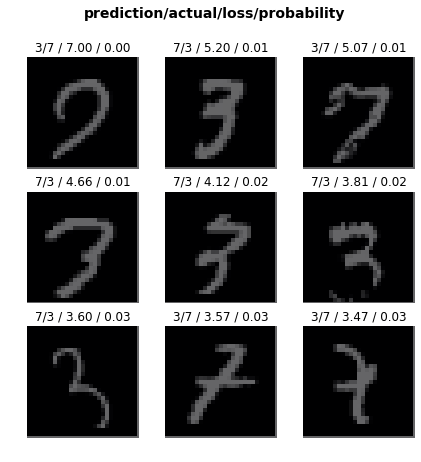

In [ ]:
interp.plot_top_losses(9, figsize=(7,7))

In [ ]:
show_doc(ClassificationInterpretation.top_losses)

<h4 id="ClassificationInterpretation.top_losses" class="doc_header"><code>top_losses</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L194" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ClassificationInterpretation-top_losses-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>top_losses</code>(**`k`**:`int`=***`None`***, **`largest`**=***`True`***)

<div class="collapse" id="ClassificationInterpretation-top_losses-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ClassificationInterpretation-top_losses-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>top_losses</code>:</p><p>Some other tests where <code>top_losses</code> is used:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_interp</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L72" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_vision_train.py::test_interp_shortcut</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L78" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`).  

Returns tuple of *(losses,indices)*.

In [ ]:
interp.top_losses(9)

(tensor([6.9999, 5.2013, 5.0712, 4.6642, 4.1224, 3.8131, 3.6013, 3.5701, 3.4746]),
 tensor([1378,  764, 1811,  983,   36,  358,  859, 1965, 1023]))

In [ ]:
show_doc(ClassificationInterpretation.plot_multi_top_losses, full_name='plot_multi_top_losses')

<h4 id="plot_multi_top_losses" class="doc_header"><code>plot_multi_top_losses</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L160" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#plot_multi_top_losses-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>plot_multi_top_losses</code>(**`samples`**:`int`=***`3`***, **`figsize`**:`Tuple`\[`int`, `int`\]=***`(8, 8)`***, **`save_misclassified`**:`bool`=***`False`***)

<div class="collapse" id="plot_multi_top_losses-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#plot_multi_top_losses-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>_cl_int_plot_multi_top_losses</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class in a multilabeled dataset.  

Similar to `plot_top_losses()` but aimed at multi-labeled datasets. It plots misclassified samples sorted by their respective loss. 
Since you can have multiple labels for a single sample, they can easily overlap in a grid plot. So it plots just one sample per row.  
Note that you can pass `save_misclassified=True` (by default it's `False`). In such case, the method will return a list containing the misclassified images which you can use to debug your model and/or tune its hyperparameters. 

In [ ]:
show_doc(ClassificationInterpretation.plot_confusion_matrix)

<h4 id="ClassificationInterpretation.plot_confusion_matrix" class="doc_header"><code>plot_confusion_matrix</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L161" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ClassificationInterpretation-plot_confusion_matrix-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>plot_confusion_matrix</code>(**`normalize`**:`bool`=***`False`***, **`title`**:`str`=***`'Confusion matrix'`***, **`cmap`**:`Any`=***`'Blues'`***, **`slice_size`**:`int`=***`1`***, **`norm_dec`**:`int`=***`2`***, **`plot_txt`**:`bool`=***`True`***, **`return_fig`**:`bool`=***`None`***, **\*\*`kwargs`**) → `Optional`\[`Figure`\]

<div class="collapse" id="ClassificationInterpretation-plot_confusion_matrix-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ClassificationInterpretation-plot_confusion_matrix-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>plot_confusion_matrix</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Plot the confusion matrix, with `title` and using `cmap`.  

If [`normalize`](/vision.data.html#normalize), plots the percentages with `norm_dec` digits. `slice_size` can be used to avoid out of memory error if your set is too big. `kwargs` are passed to `plt.figure`.

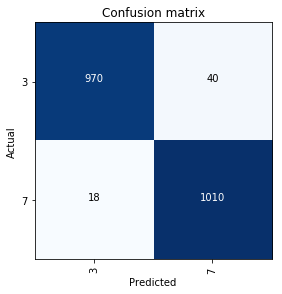

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
show_doc(ClassificationInterpretation.confusion_matrix)

<h4 id="ClassificationInterpretation.confusion_matrix" class="doc_header"><code>confusion_matrix</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L149" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ClassificationInterpretation-confusion_matrix-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>confusion_matrix</code>(**`slice_size`**:`int`=***`1`***)

<div class="collapse" id="ClassificationInterpretation-confusion_matrix-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ClassificationInterpretation-confusion_matrix-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>confusion_matrix</code>:</p><ul><li><code>pytest -sv tests/test_tabular_train.py::test_confusion_tabular</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_tabular_train.py#L84" class="source_link" style="float:right">[source]</a></li></ul><p>Some other tests where <code>confusion_matrix</code> is used:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_ClassificationInterpretation</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L95" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Confusion matrix as an `np.ndarray`.  

In [ ]:
interp.confusion_matrix()

array([[ 970,   40],
       [  18, 1010]])

In [ ]:
show_doc(ClassificationInterpretation.most_confused)

<h4 id="ClassificationInterpretation.most_confused" class="doc_header"><code>most_confused</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L186" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ClassificationInterpretation-most_confused-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>most_confused</code>(**`min_val`**:`int`=***`1`***, **`slice_size`**:`int`=***`1`***) → `Collection`\[`Tuple`\[`str`, `str`, `int`\]\]

<div class="collapse" id="ClassificationInterpretation-most_confused-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ClassificationInterpretation-most_confused-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>most_confused</code>:</p><p>Some other tests where <code>most_confused</code> is used:</p><ul><li><code>pytest -sv tests/test_vision_train.py::test_ClassificationInterpretation</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_train.py#L95" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences.  

#### Working with large datasets

When working with large datasets, memory problems can arise when computing the confusion matrix. For example, an error can look like this:

    RuntimeError: $ Torch: not enough memory: you tried to allocate 64GB. Buy new RAM!

In this case it is possible to force [`ClassificationInterpretation`](/train.html#ClassificationInterpretation) to compute the confusion matrix for data slices and then aggregate the result by specifying slice_size parameter. 

In [ ]:
interp.confusion_matrix(slice_size=10)

array([[ 970,   40],
       [  18, 1010]])

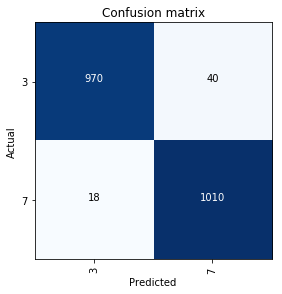

In [ ]:
interp.plot_confusion_matrix(slice_size=10)

In [ ]:
interp.most_confused(slice_size=10)

[('3', '7', 40), ('7', '3', 18)]

## Undocumented Methods - Methods moved below this line will intentionally be hidden

## New Methods - Please document or move to the undocumented section